In [1]:
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import copy
from math import trunc
import email
import spacy
import tqdm
nlp=spacy.load("en_core_web_sm",disable=["tagger", "parser","ner"])  #Only Tokennize
plt.rc('font', size="12")

In [2]:
id_to_top_cat={1: "Coarse genre",
         2: "Included/forwarded information",
         3: "Primary topics",
         4: "Emotional tone"}

id_to_sub_cat={1: {1: "Company Business, Strategy",
             2: "Purely Personal",
             3: "Personal but in professional context",
             4: "Logistic Arrangements",
             5: "Employment arrangements",
             6: "Document editing/checking",
             7: "Empty message (missing attachment)",
             8: "Empty message"},

         2: {1 : "Includes new text in addition to forwarded material",
             2 : "Forwarded email(s) including replies",
             3 : "Business letter(s) / document(s)",
             4 : "News article(s)",
             5 : "Government / academic report(s)",
             6 : "Government action(s)",
             7 : "Press release(s)",
             8 : "Legal documents",
             9 : "Pointers to url(s)",
             10: "Newsletters",
             11: "Jokes, humor (related to business)",
             12: "Jokes, humor (unrelated to business)",
             13: "Attachment(s) (assumed missing)"},

         3:{ 1  : "regulations and regulators (includes price caps)",
             2  : "internal projects -- progress and strategy",
             3  : "company image -- current",
             4  : "company image -- changing / influencing",
             5  : "political influence / contributions / contacts",
             6  : "california energy crisis / california politics",
             7  : "internal company policy",
             8  : "internal company operations",
             9  : "alliances / partnerships",
             10 : "legal advice",
             11 : "talking points",
             12 : "meeting minutes",
             13 : "trip reports"},

         4:{ 1  : "jubilation",
             2  : "hope / anticipation",
             3  : "humor",
             4  : "camaraderie",
             5  : "admiration",
             6  : "gratitude",
             7  : "friendship / affection",
             8  : "sympathy / support",
             9  : "sarcasm",
             10 : "secrecy / confidentiality",
             11 : "worry / anxiety",
             12 : "concern",
             13 : "competitiveness / aggressiveness",
             14 : "triumph / gloating",
             15 : "pride",
             16 : "anger / agitation",
             17 : "sadness / despair",
             18 : "shame",
             19 : "dislike / scorn"}}

In [3]:
def get_labels(filename):
    with open(filename + '.cats') as f:
        labels = defaultdict(dict)
        line = f.readline()
        while line:
            line = line.split(',')
            top_cat, sub_cat, freq = int(line[0]), int(line[1]), int(line[2])
            labels[top_cat][sub_cat] = freq
            line = f.readline()
    return dict(labels)

def check_category(filename, top_cat, sub_cat):
    labels = get_labels(filename)
    if sub_cat in labels[top_cat]:
        return 1
    return 0

def get_binary_labels(filenames, top_cat, sub_cat):
    flags = []
    for filename in filenames:
        flags.append(check_category(filename, top_cat, sub_cat))
    return flags

In [4]:
print(glob.glob('./*/*/*.cats'))

['.\\enron_with_categories\\1\\10425.cats', '.\\enron_with_categories\\1\\106296.cats', '.\\enron_with_categories\\1\\106298.cats', '.\\enron_with_categories\\1\\106588.cats', '.\\enron_with_categories\\1\\106590.cats', '.\\enron_with_categories\\1\\109359.cats', '.\\enron_with_categories\\1\\110549.cats', '.\\enron_with_categories\\1\\113953.cats', '.\\enron_with_categories\\1\\114087.cats', '.\\enron_with_categories\\1\\114503.cats', '.\\enron_with_categories\\1\\114715.cats', '.\\enron_with_categories\\1\\114844.cats', '.\\enron_with_categories\\1\\114845.cats', '.\\enron_with_categories\\1\\114847.cats', '.\\enron_with_categories\\1\\115139.cats', '.\\enron_with_categories\\1\\115140.cats', '.\\enron_with_categories\\1\\115175.cats', '.\\enron_with_categories\\1\\115317.cats', '.\\enron_with_categories\\1\\115322.cats', '.\\enron_with_categories\\1\\115333.cats', '.\\enron_with_categories\\1\\115439.cats', '.\\enron_with_categories\\1\\115495.cats', '.\\enron_with_categories\\1\\11

In [5]:
email_files = [f.replace('.cats', '') for f in glob.glob('./*/*/*.cats')]
top_cnt=dict([(k,0) for k,v in id_to_top_cat.items()])
category_freq = dict([(k,dict([(k2,0) for k2,_ in v.items()])) for k,v in id_to_sub_cat.items()])
category_cnt = copy.deepcopy(category_freq)
total_freq = 0
label_freq = 0
labeled_files = []

for email_file in email_files:
    labels = get_labels(email_file)
    for top_cat in labels:
        top_cnt[top_cat]+=1
        for sub_cat in labels[top_cat]:
            total_freq += labels[top_cat][sub_cat]

    
        has_label = False
        for sub_cat in labels[top_cat]:
            freq = labels[top_cat][sub_cat]
            category_freq[top_cat][sub_cat] += freq
            category_cnt[top_cat][sub_cat] += 1
            label_freq += freq
            has_label = True
        if has_label:
            labeled_files.append(email_file)

In [6]:
def plot_freq(x_dict,cnt_dict,figsize=(10,5),xlabel="",title=""):
    x,y=[],[]
    for k,v in x_dict.items():
        x.append(v)
        y.append(cnt_dict[k])
    y=np.array(y)
    y_srt=np.argsort(y)
    x=np.array(x)[y_srt]
    y=y[y_srt]
    plt.figure(figsize=figsize)
    ax=plt.subplot()
    _=ax.barh(x,y)
    max_x=max(y)
    #tick_gap=50 if max_x%1000==max_x else 100
    #_=ax.set_xticks(range(0,max_x+tick_gap,tick_gap))
    tick_gap=ax.get_xticks()[1]-ax.get_xticks()[0]
    ax.set_xlim(0,round(max_x,-1)+tick_gap/2)
    _=ax.set_yticks(range(len(x)))
    #_=ax.set_yticklabels(x, rotation = rotation,ha=ha)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for k,v in enumerate(y):
        ax.annotate(v,(v-len(str(v))*(tick_gap/8),k-.1),color="white")

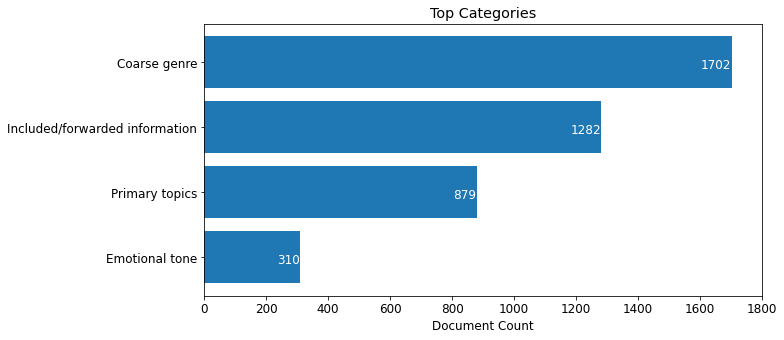

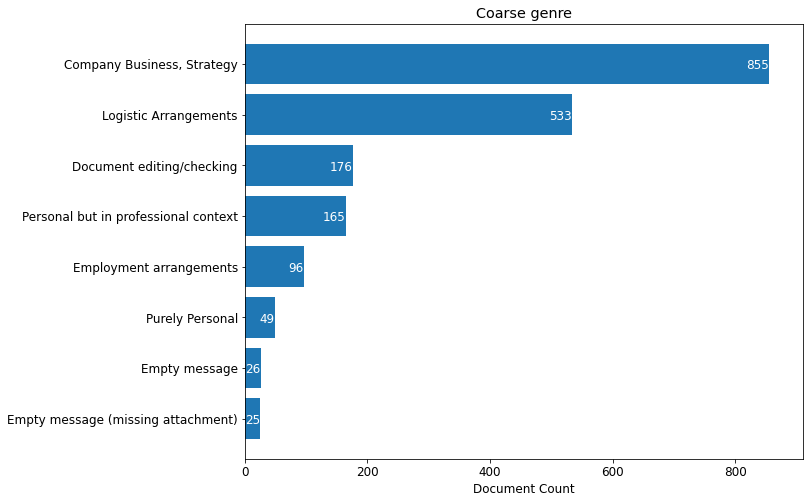

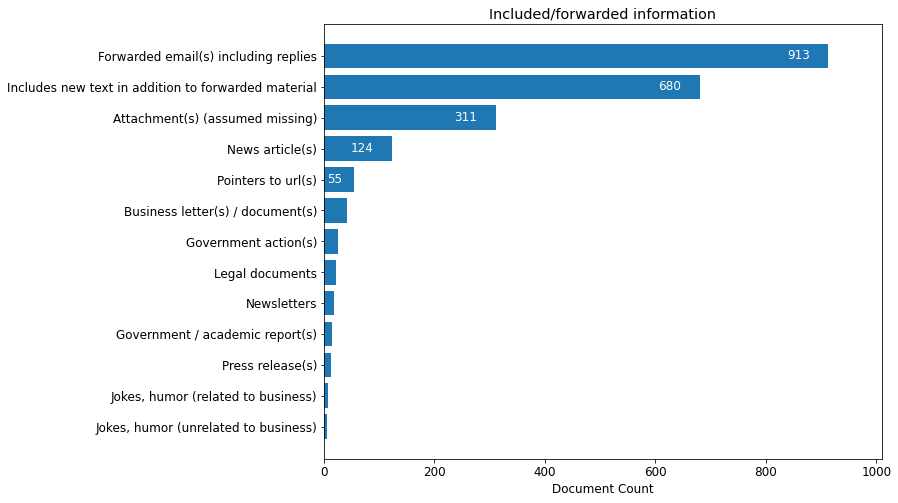

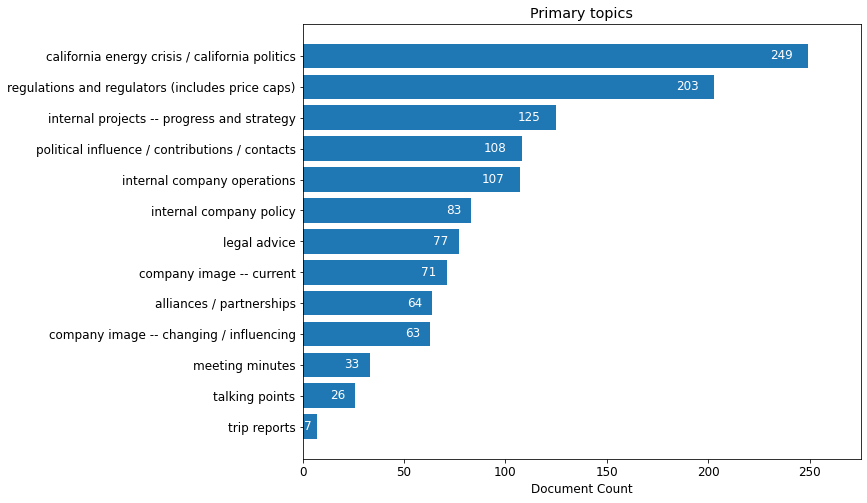

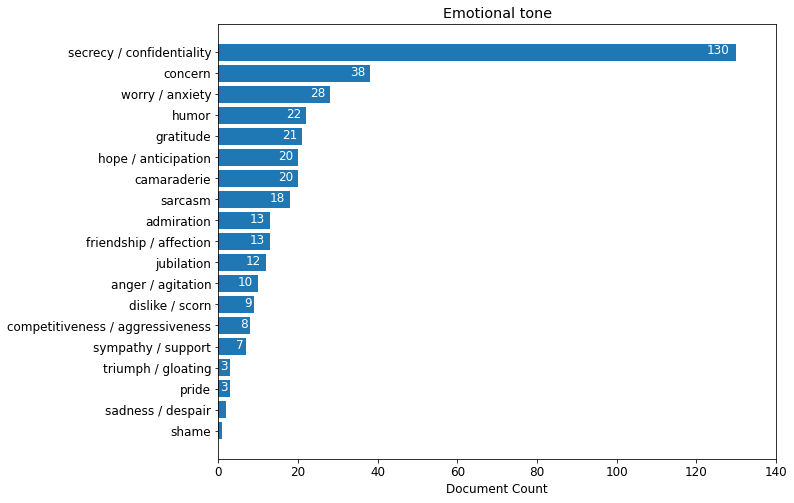

In [7]:
x=[id_to_top_cat[k] for k in top_cnt.keys()]
plot_freq(id_to_top_cat,top_cnt,xlabel="Document Count",title="Top Categories")
for k in category_cnt:
    plot_freq(id_to_sub_cat[k],category_cnt[k],figsize=(10,8),xlabel="Document Count",title=id_to_top_cat[k])

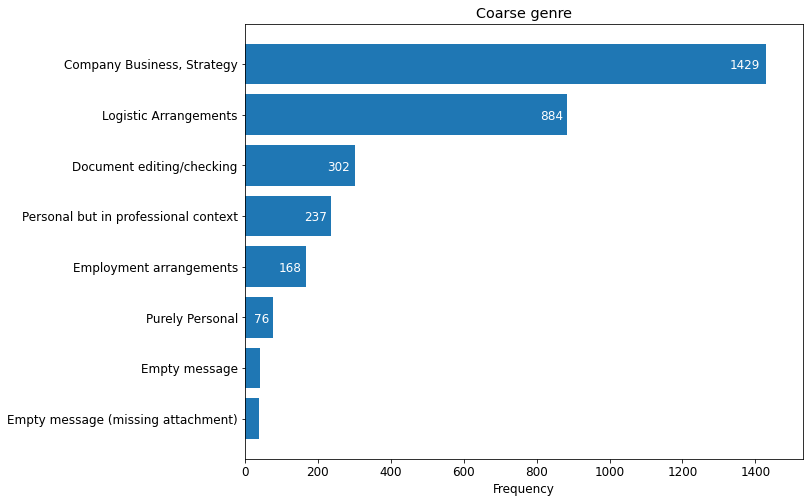

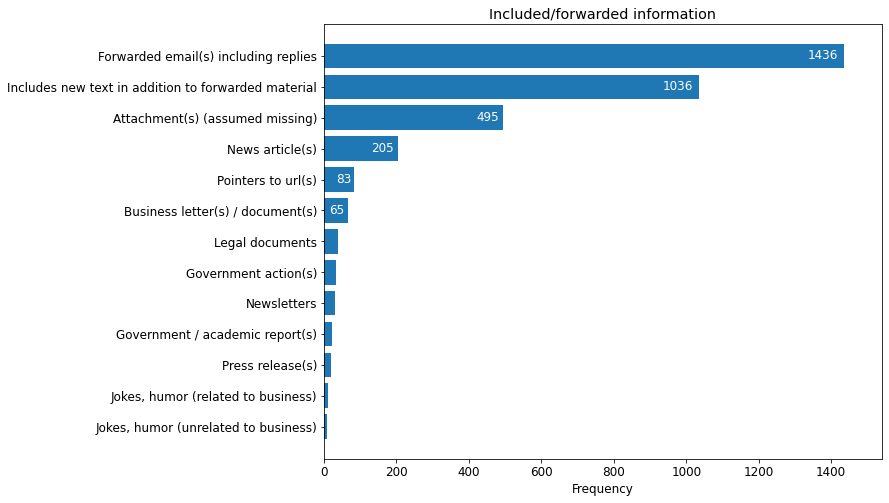

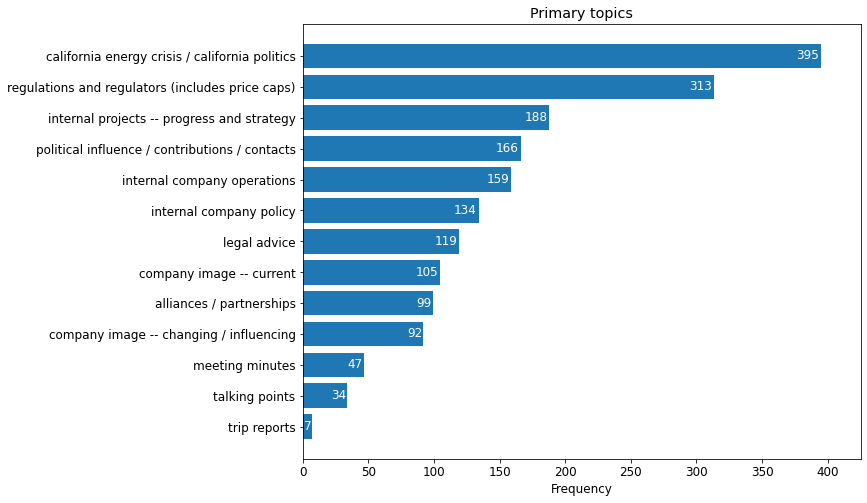

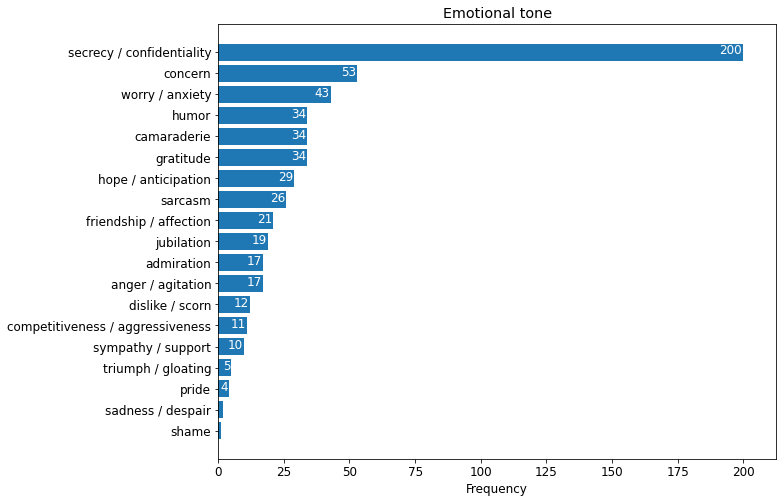

In [8]:
for k in category_freq:
    plot_freq(id_to_sub_cat[k],category_freq[k],figsize=(10,8),xlabel="Frequency",title=id_to_top_cat[k])

## Preprocess

In [9]:
def nlp_tokenize_lower(string):
    return [token.text.lower() for token in nlp(string)]

In [10]:
def read_email_file(filename):
    with open(filename) as f:
        message = email.message_from_file(f)
    return message.get_payload()

In [11]:
def preprocess(filename):
    
    message=read_email_file(filename)
    words = []
    message_count = 1
    include_text = True
    for line in message.split('\n'):

        # exclude forwarded information
        if ('forwarded' in line.lower() or 'original' in line.lower()) and '--' in line:
            message_count += 1
            include_text = False
        if include_text:
            words.extend(nlp_tokenize_lower(line))
    
    tos = [address.strip() for address in (message['To'] or '').split(',')]
    froms = [address.strip() for address in (message['From'] or '').split(',')]
    
    return {"message":words, "to": tos, "from": froms, "count": message_count}

In [12]:
content=[]
for f in tqdm.tqdm(email_files):
    content.append(preprocess(f+".txt"))

  0%|          | 0/1702 [00:00<?, ?it/s]


TypeError: string indices must be integers

In [ ]:
vocab={}
for c in tqdm.tqdm(content):
    for w in c["message"]:
        if w in vocab:
            vocab[w]+=1
        else:
            vocab[w]=1

100%|██████████| 1702/1702 [00:00<00:00, 7027.31it/s]


: 

In [ ]:
message_length=np.array([len(c["message"]) for c in content])

: 

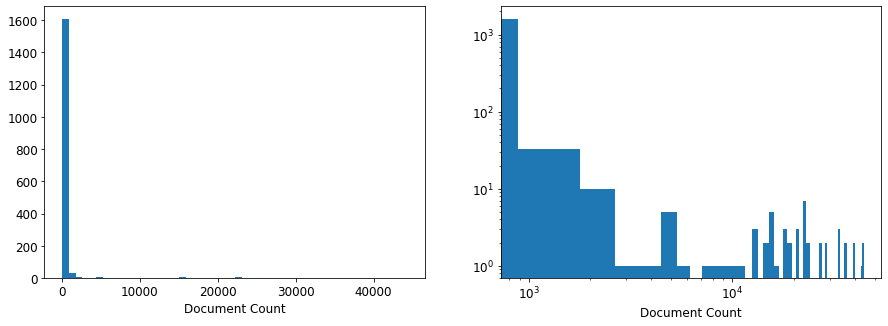

: 

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
ax=axs[0]
for ax in axs:
    _=ax.hist(message_length,bins=50)
    _=ax.set_xlabel("words")
    _=ax.set_xlabel("Document Count")

axs[1].set_yscale("log")
axs[1].set_xscale("log")

In [ ]:
def pct_length(pct_at,text=True):
    res=round(100*message_length[message_length<pct_at].shape[0]/message_length.shape[0],2)
    if(text):
        return f"Documents with atleast {pct_at} words\t: {res}%"
    else:
        return res

: 

In [ ]:
print(f"Total Documents: {len(email_files)}")
print(f"Mean Document length (words): {round(np.mean(message_length),2)}")
print(f"Unique words: {len(vocab)}")
print(pct_length(512))
print(pct_length(1000))

Total Documents: 1702
Mean Document length (words): 784.39
Unique words: 31742
Documents with atleast 512 words	: 90.01%
Documents with atleast 1000 words	: 94.54%


: 

In [ ]:
lbls=get_labels(email_files[1])

: 

In [ ]:
lbls

{1: {1: 2}, 2: {1: 2, 4: 2, 13: 1}, 3: {10: 2}}

: 

In [ ]:
lbls.items()

dict_items([(1, {1: 2}), (2, {1: 2, 4: 2, 13: 1}), (3, {10: 2})])

: 

In [ ]:
m_top,m_sub

(1, 1)

: 

In [ ]:
def get_max_categ(lbls):
    m_top,m_sub=0,0
    mx=0
    for tk,tv in lbls.items():
        for sk,sv in tv.items():
            if sv>mx:
                m_top,m_sub=tk,sk
                mx=sv
    return m_top,m_sub

: 

In [ ]:
top,sub=2,13
for idx,file in enumerate(email_files):
    lbls=get_labels(file)
    m_top,m_sub=get_max_categ(lbls)
    if(top == m_top and sub ==m_sub):
        print(file,lbls[top][sub],read_email_file(file+".txt"))
        break

./1/54646 2 

 -----Original Message-----
From: 	Bharati, Rakesh  
Sent:	Thursday, June 28, 2001 1:24 AM
To:	Kaminski, Vince J; Huson, Margaret
Subject:	Note on liquidity



Attached is a brief note on liquidity with references to a couple of surveys which provide further information.  My attempt was to write at a reasonable degree of simplicity while providing a general familiarity with the attendant issues.  Please comment.  Thanks.

Also, Profs. Maureen O'Hara, Lawrence Glosten, Haim Mendelson, Joel Hasbrouck, Hans Stoll, Albert Kyle, Lawerence Harris, and Ananth Madhavan are some of the leading academics in the field.


Rakesh


 


: 

In [ ]:
category_freq

{1: {1: 1429, 2: 76, 3: 237, 4: 884, 5: 168, 6: 302, 7: 40, 8: 42},
 2: {1: 1036,
  2: 1436,
  3: 65,
  4: 205,
  5: 21,
  6: 34,
  7: 20,
  8: 38,
  9: 83,
  10: 31,
  11: 11,
  12: 8,
  13: 495},
 3: {1: 313,
  2: 188,
  3: 105,
  4: 92,
  5: 166,
  6: 395,
  7: 134,
  8: 159,
  9: 99,
  10: 119,
  11: 34,
  12: 47,
  13: 7},
 4: {1: 19,
  2: 29,
  3: 34,
  4: 34,
  5: 17,
  6: 34,
  7: 21,
  8: 10,
  9: 26,
  10: 200,
  11: 43,
  12: 53,
  13: 11,
  14: 5,
  15: 4,
  16: 17,
  17: 2,
  18: 1,
  19: 12}}

: 